In [1]:
!pip install ultralytics kagglehub --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.4 MB/s eta 0:00:00


In [ ]:
#Installing kagglehub to download dataset
import kagglehub

path = kagglehub.dataset_download("mexwell/trashcan-1-0")
print(path)


Using Colab cache for faster access to the 'trashcan-1-0' dataset.
/kaggle/input/trashcan-1-0


In [ ]:
#Accessing datset files from Os
import os

for root, dirs, files in os.walk(path):
    print(root, len(files), "files")


/kaggle/input/trashcan-1-0 0 files
/kaggle/input/trashcan-1-0/dataset 1 files
/kaggle/input/trashcan-1-0/dataset/scripts 1 files
/kaggle/input/trashcan-1-0/dataset/original_data 1 files
/kaggle/input/trashcan-1-0/dataset/original_data/annotations 7212 files
/kaggle/input/trashcan-1-0/dataset/original_data/images 7212 files
/kaggle/input/trashcan-1-0/dataset/material_version 3 files
/kaggle/input/trashcan-1-0/dataset/material_version/val 1204 files
/kaggle/input/trashcan-1-0/dataset/material_version/train 6008 files
/kaggle/input/trashcan-1-0/dataset/instance_version 3 files
/kaggle/input/trashcan-1-0/dataset/instance_version/val 1147 files
/kaggle/input/trashcan-1-0/dataset/instance_version/train 6065 files


In [ ]:
#Reading a 5 file sample from the dataset
import json
import random

ann_path = "/kaggle/input/trashcan-1-0/dataset/original_data/annotations"
sample_files = random.sample(os.listdir(ann_path), 5)

print("Sample annotation files:", sample_files)
print("\n---- Preview ----\n")

for f in sample_files:
    with open(os.path.join(ann_path, f), "r") as file:
        data = json.load(file)
        print("File:", f)
        print("Keys:", data.keys())
        print("Number of objects:", len(data.get("shapes", [])))
        if len(data.get("shapes", [])) > 0:
            print("First object:", data["shapes"][0])
        print("\n")


Sample annotation files: ['vid_000438_frame0000046.jpg.json', 'vid_000147_frame0000005.jpg.json', 'vid_000253_frame0000001.jpg.json', 'vid_000145_frame0000042.jpg.json', 'vid_000342_frame0000269.jpg.json']

---- Preview ----

File: vid_000438_frame0000046.jpg.json
Keys: dict_keys(['description', 'tags', 'size', 'objects'])
Number of objects: 0


File: vid_000147_frame0000005.jpg.json
Keys: dict_keys(['description', 'tags', 'size', 'objects'])
Number of objects: 0


File: vid_000253_frame0000001.jpg.json
Keys: dict_keys(['description', 'tags', 'size', 'objects'])
Number of objects: 0


File: vid_000145_frame0000042.jpg.json
Keys: dict_keys(['description', 'tags', 'size', 'objects'])
Number of objects: 0


File: vid_000342_frame0000269.jpg.json
Keys: dict_keys(['description', 'tags', 'size', 'objects'])
Number of objects: 0




In [ ]:

#Reading total amount of image files with an example file name
ann_dir = "/kaggle/input/trashcan-1-0/dataset/original_data/annotations"

count_with_objects = 0
example_file = None

for f in os.listdir(ann_dir):
    file_path = os.path.join(ann_dir, f)
    with open(file_path, "r") as fp:
        data = json.load(fp)
        if len(data.get("objects", [])) > 0:
            count_with_objects += 1
            if example_file is None:
                example_file = f

count_with_objects, example_file


(7212, 'vid_000331_frame0000177.jpg.json')

In [ ]:
#Opening the example file and showing its contents

ann_dir = "/kaggle/input/trashcan-1-0/dataset/original_data/annotations"
file = "vid_000331_frame0000177.jpg.json"

with open(os.path.join(ann_dir, file), "r") as f:
    data = json.load(f)

data


{'description': '',
 'tags': [],
 'size': {'height': 270, 'width': 480},
 'objects': [{'id': 411092111,
   'classId': 1400966,
   'description': '',
   'geometryType': 'bitmap',
   'labelerLogin': 'jasonsf',
   'createdAt': '2020-04-06T02:44:01.363Z',
   'updatedAt': '2020-04-06T02:44:01.363Z',
   'tags': [{'id': 27641173,
     'name': 'material',
     'value': 'metal',
     'labelerLogin': 'jasonsf',
     'createdAt': '2020-04-06T02:44:01.290Z',
     'updatedAt': '2020-04-06T02:44:01.290Z'},
    {'id': 27641178,
     'name': 'instance',
     'value': 'can',
     'labelerLogin': 'jasonsf',
     'createdAt': '2020-04-06T02:44:01.290Z',
     'updatedAt': '2020-04-06T02:44:01.290Z'}],
   'classTitle': 'trash',
   'bitmap': {'data': 'eJwB0AQv+4lQTkcNChoKAAAADUlIRFIAAABBAAAATggGAAAAf6F7kAAABJdJREFUeF7VnE3oZ1MYxz9fLxkzGqFEJJO8FMmCLLCyoBSKjWgWpBQiNTs2XjZKKJmyIE2smCnDxkYRiY2JqFHDRBmlkJdhZsyjZ7q/f7/5/17uOfd3nnPvvdvfOc/L5zzn5T7nuT+xwmNmvwGnLxBhwEFgh6QHVlAT3lW5GszsJmA3cHJm3yPAL8B2SU9m9g1tngzBzHYC

In [7]:
!pip install pillow opencv-python-headless numpy tqdm


In [ ]:
#Creating image and label folders

output_dir = "/content/dataset"
images_out = output_dir + "/images"
labels_out = output_dir + "/labels"

os.makedirs(images_out, exist_ok=True)
os.makedirs(labels_out, exist_ok=True)

print("Folders created:")
print(images_out)
print(labels_out)


Folders created:
/content/dataset/images
/content/dataset/labels


In [ ]:
#Image to mask function
import zlib
import numpy as np
import base64
import io
from PIL import Image

def decode_trashcan_bitmap(bitmap):
    """
    Decodes the TrashCan dataset bitmap:
    base64 → zlib → PNG → mask
    returns: numpy mask array (0/255)
    """
    compressed = base64.b64decode(bitmap["data"])
    decompressed = zlib.decompress(compressed)

    # load as image
    mask_img = Image.open(io.BytesIO(decompressed)).convert("L")
    mask = np.array(mask_img)

    # mask is usually 0 or 1, convert to full mask
    mask = (mask > 0).astype(np.uint8)

    # apply origin offset later
    return mask


In [ ]:
#Mask to bounding box for YOLO function
from tqdm import tqdm
import shutil

img_dir = "/kaggle/input/trashcan-1-0/dataset/original_data/images"

def mask_to_bbox(mask, origin, img_w, img_h):
    ys, xs = np.where(mask > 0)

    if len(xs) == 0:
        return None

    xs = xs + origin[0]
    ys = ys + origin[1]

    x_min = np.min(xs)
    x_max = np.max(xs)
    y_min = np.min(ys)
    y_max = np.max(ys)

    x_center = ((x_min + x_max) / 2) / img_w
    y_center = ((y_min + y_max) / 2) / img_h
    w = (x_max - x_min) / img_w
    h = (y_max - y_min) / img_h

    return x_center, y_center, w, h


print("Converting TrashCan bitmaps → YOLO bboxes...\n")

for json_file in tqdm(os.listdir(ann_dir)):
    json_path = os.path.join(ann_dir, json_file)

    with open(json_path, "r") as f:
        data = json.load(f)

    img_name = json_file.replace(".json", "")
    img_path = os.path.join(img_dir, img_name)

    out_img_path = os.path.join(images_out, img_name)
    out_txt_path = os.path.join(labels_out, img_name.replace(".jpg", ".txt").replace(".png", ".txt"))

    if os.path.exists(img_path):
        shutil.copy(img_path, out_img_path)
    else:
        continue

    img_w = data["size"]["width"]
    img_h = data["size"]["height"]

    yolo_lines = []

    for obj in data["objects"]:
        bitmap = obj["bitmap"]
        origin = bitmap["origin"]

        mask = decode_trashcan_bitmap(bitmap)
        bbox = mask_to_bbox(mask, origin, img_w, img_h)

        if bbox is None:
            continue

        yolo_lines.append(f"0 {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}")

    with open(out_txt_path, "w") as f:
        f.write("\n".join(yolo_lines))

print("DONE — REAL bounding boxes created.")


Converting TrashCan bitmaps → YOLO bboxes...



100%|██████████| 7212/7212 [00:27<00:00, 264.66it/s]

DONE — REAL bounding boxes created.


In [ ]:
#check to ensure all files in the dataset were converted
count_empty = 0
count_nonempty = 0

for f in os.listdir("/content/dataset/labels"):
    if os.path.getsize("/content/dataset/labels/" + f) == 0:
        count_empty += 1
    else:
        count_nonempty += 1

count_empty, count_nonempty


(0, 7212)

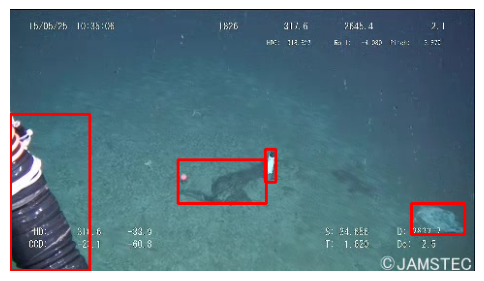

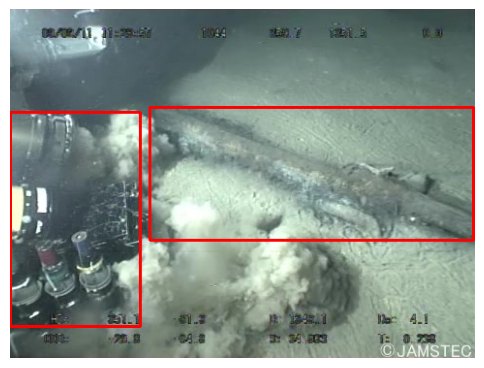

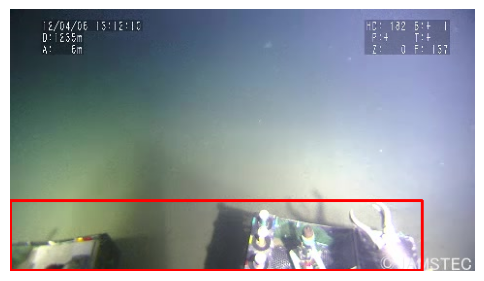

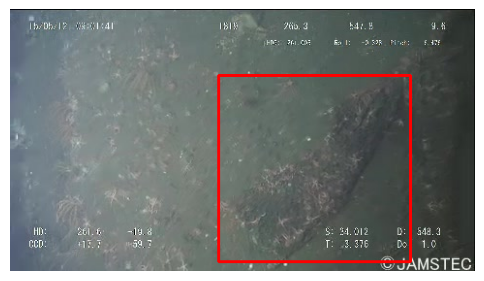

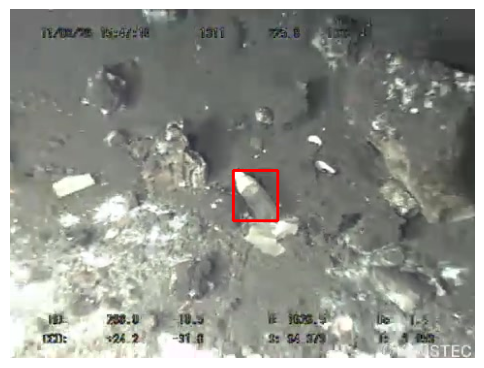

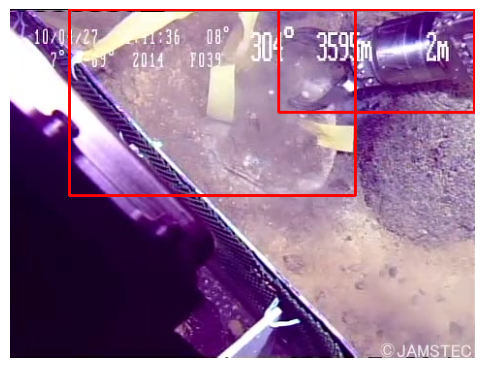

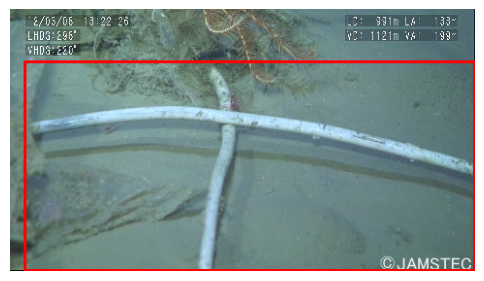

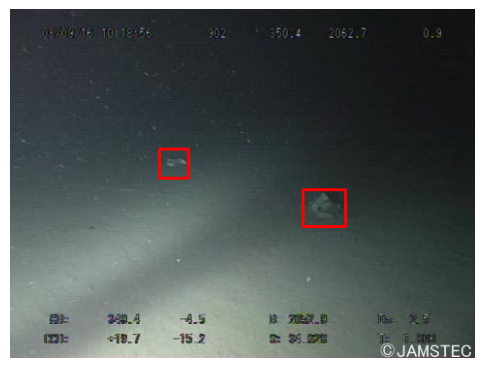

In [ ]:
import cv2
import matplotlib.pyplot as plt


img_dir = "/content/dataset/images"
lbl_dir = "/content/dataset/labels"

def show_random(n=8):
    files = random.sample(os.listdir(img_dir), n)

    for file in files:
        img_path = os.path.join(img_dir, file)
        lbl_path = os.path.join(lbl_dir, file.replace(".jpg", ".txt").replace(".png", ".txt"))

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        h, w, _ = img.shape

        # draw boxes
        with open(lbl_path) as f:
            lines = f.readlines()

        for line in lines:
            cls, xc, yc, bw, bh = map(float, line.split())

            x1 = int((xc - bw/2) * w)
            y1 = int((yc - bh/2) * h)
            x2 = int((xc + bw/2) * w)
            y2 = int((yc + bh/2) * h)

            cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)

        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.axis("off")
        plt.show()

show_random(8)


In [ ]:
#Data serialization
yaml_text = """
train: /content/dataset/images
val: /content/dataset/images

nc: 1
names: ['trash']
"""

with open("/content/data.yaml", "w") as f:
    f.write(yaml_text)

print(open("/content/data.yaml").read())



train: /content/dataset/images
val: /content/dataset/images

nc: 1
names: ['trash']



In [ ]:
#Training YOLO model
from ultralytics import YOLO

model = YOLO("yolov8m.pt")

model.train(
    data="/content/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    project="/content/drive/MyDrive",
    name="trashcan_model"
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj

KeyboardInterrupt: 

In [ ]:
#Validation of model
model = YOLO("/content/drive/MyDrive/trashcan_model/weights/best.pt")
model.val()


Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 713.6±307.5 MB/s, size: 22.8 KB)
val: Scanning /content/dataset/labels.cache... 7212 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 7212/7212 7.3Mit/s 0.0s
train: /content/dataset/images/vid_000143_frame0000013.jpg: 1 duplicate labels removed
train: /content/dataset/images/vid_000145_frame0000028.jpg: 1 duplicate labels removed
train: /content/dataset/images/vid_000532_frame0000001.jpg: 1 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 451/451 3.6it/s 2:07
                   all       7212      12477      0.915      0.844      0.923      0.702
Speed: 0.6ms preprocess, 13.4ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /content/runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x788bce66a030>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:


for root, dirs, files in os.walk("runs/detect", topdown=True):
    print(root, files)


runs/detect []
runs/detect/val ['BoxF1_curve.png', 'val_batch1_labels.jpg', 'val_batch0_pred.jpg', 'val_batch2_labels.jpg', 'BoxR_curve.png', 'val_batch0_labels.jpg', 'confusion_matrix.png', 'val_batch1_pred.jpg', 'val_batch2_pred.jpg', 'confusion_matrix_normalized.png', 'BoxP_curve.png', 'BoxPR_curve.png']


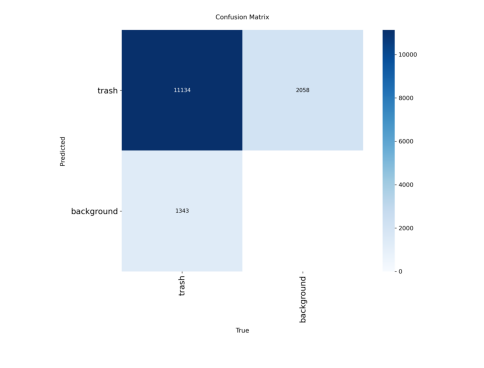

In [ ]:
#Graphical demo of confusion matrix
import matplotlib.image as mpimg

img = mpimg.imread("runs/detect/val/confusion_matrix.png")
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.show()


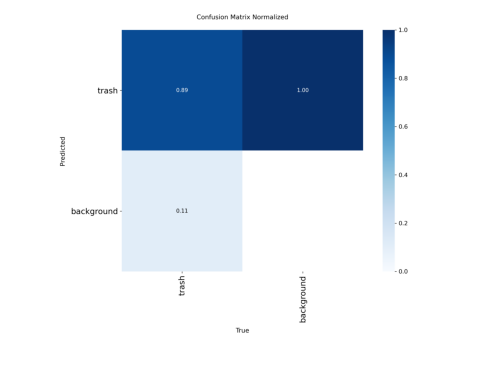

In [ ]:
#Graphical demo of normalized confusion matrix
img = mpimg.imread("runs/detect/val/confusion_matrix_normalized.png")
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.show()

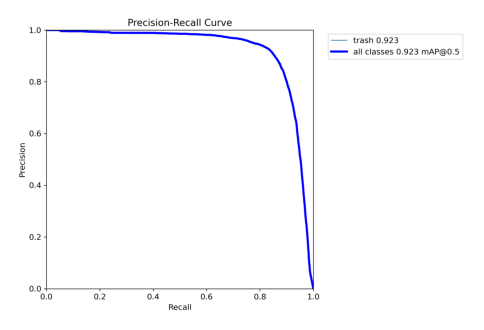

In [ ]:
#Precision-recall curve
img = mpimg.imread("runs/detect/val/BoxPR_curve.png")
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.show()

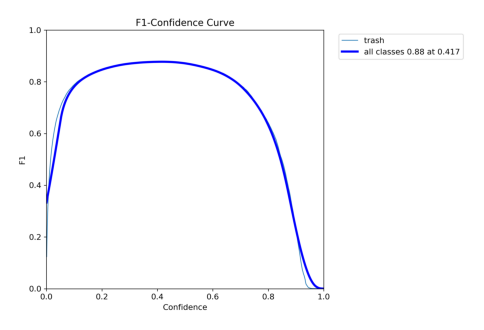

In [ ]:
#F1-Confidence Curve
img = mpimg.imread("runs/detect/val/BoxF1_curve.png")
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.show()

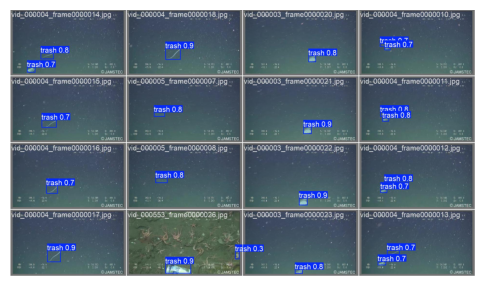

In [44]:
#show Prediction Sample #1
img = mpimg.imread("runs/detect/val/val_batch0_pred.jpg")

plt.figure(figsize=(6,6))  # adjust if needed
plt.imshow(img)
plt.axis("off")
plt.show()

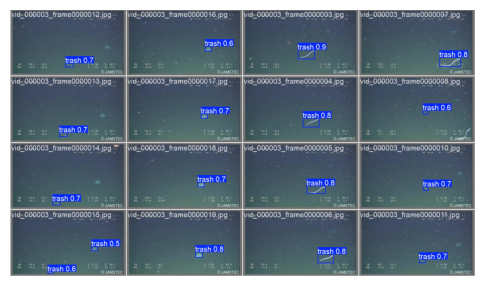

In [45]:
#show Prediction Sample #2
img = mpimg.imread("runs/detect/val/val_batch1_pred.jpg")

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.show()

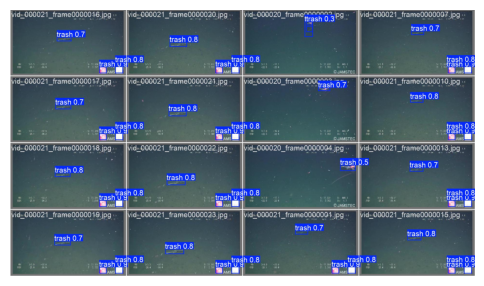

In [43]:
#show Prediction Sample #3
img = mpimg.imread("runs/detect/val/val_batch2_pred.jpg")

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.show()

In [47]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/trashcan_model/results.csv")
df.tail()   # shows last 5 rows (final metrics)

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
17,18,5751.33,1.02455,0.88951,1.24402,0.86918,0.81927,0.89272,0.65565,0.93535,0.69836,1.13798,0.001327,0.001327,0.001327
18,19,6074.29,1.01884,0.88226,1.24080,0.87852,0.83161,0.90478,0.67555,0.91905,0.64569,1.12739,0.001287,0.001287,0.001287
19,20,6395.50,0.99955,0.84638,1.22452,0.88701,0.83114,0.90556,0.67581,0.91840,0.65956,1.12071,0.001248,0.001248,0.001248
20,21,6716.84,0.99585,0.84611,1.22263,0.89004,0.83602,0.90787,0.68102,0.90703,0.63220,1.11615,0.001208,0.001208,0.001208
21,22,7039.72,0.99053,0.82689,1.22103,0.91517,0.84390,0.92324,0.70132,0.87453,0.59253,1.09339,0.001168,0.001168,0.001168


In [52]:
#final model metrics
for metric in [
    "metrics/precision(B)",
    "metrics/recall(B)",
    "metrics/mAP50(B)",
    "metrics/mAP50-95(B)"
]:
    print(f"{metric}: {df.iloc[-1][metric]:.3f}")


metrics/precision(B): 0.915
metrics/recall(B): 0.844
metrics/mAP50(B): 0.923
metrics/mAP50-95(B): 0.701
